In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) 

In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [4]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv", parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv", parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
# Same thing as train and test dataset
submission = pd.read_csv("/kaggle/input/bike-sharing-demand/sampleSubmission.csv", parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


**Train a model using AutoGluon’s Tabular Prediction**

In [ ]:
## Requirements:
# We are prediting count, so it is the label we are setting.
# Ignore 'casual' and 'registered' columns as they are also not present in the test dataset.
# Use the root_mean_squared_error as the metric to use for evaluation.
# Set a time limit of 10 minutes (600 seconds).
# Use the preset best_quality to focus on creating the best model.
train_data = train.drop(columns=['casual', 'registered'])

# Train AutoGluon model
predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data, 
    time_limit=600,  # 10 minutes
    presets="best_quality"
)

In [ ]:
predictor.fit_summary()

In [ ]:
# Generate predictions on the test dataset
predictions = predictor.predict(test)

# Display the first few predictions
predictions.head()

In [ ]:
predictions.describe()

In [ ]:
# Create a submission DataFrame
submission = pd.DataFrame({
    "datetime": test["datetime"],  # Use the datetime from the test dataset
    "count": predictions           # Use our predicted values
})

# Display the first few rows
submission.head()

In [ ]:
# Save submission to a CSV file (without the index column)
submission.to_csv("/kaggle/working/submission.csv", index=False)

Initial score of 1.80574

**Exploratory Data Analysis and Creating an additional feature**

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

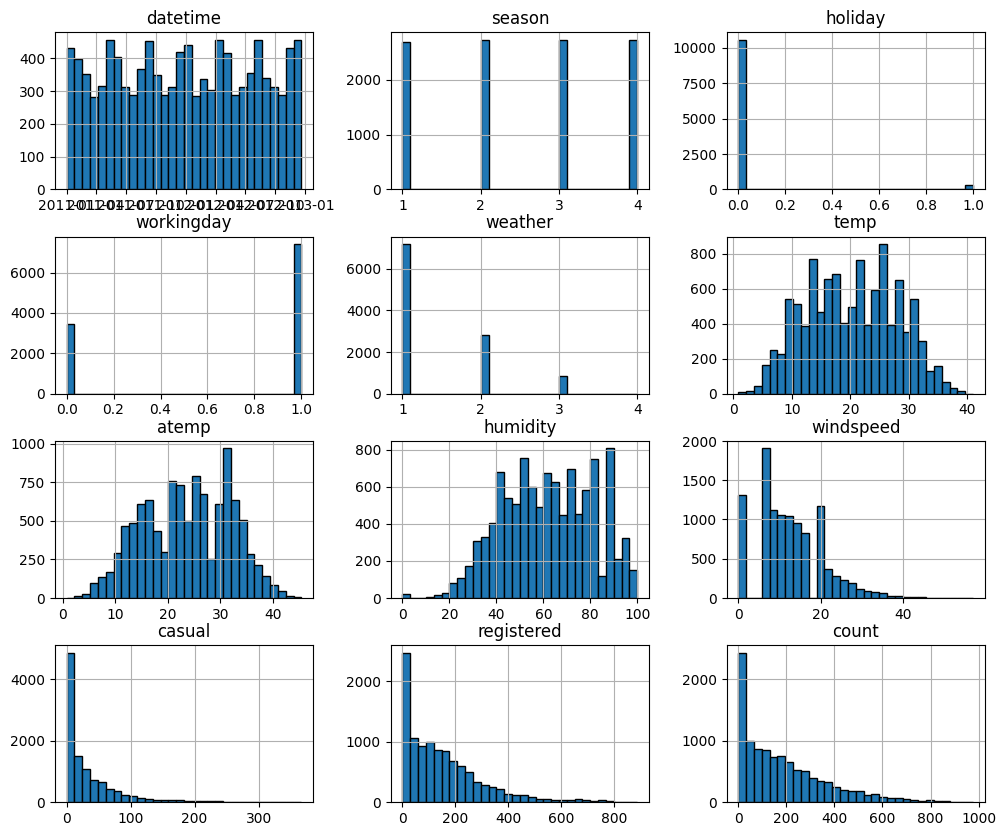

In [7]:
# Plot histograms for all numerical features in the training dataset
train.hist(figsize=(12, 10), bins=30, edgecolor='black')

In [9]:
# Extract hour, day, month, and day of the week from the datetime column
train["hour"] = train["datetime"].dt.hour
train["day"] = train["datetime"].dt.day
train["month"] = train["datetime"].dt.month
train["dayofweek"] = train["datetime"].dt.dayofweek

test["hour"] = test["datetime"].dt.hour
test["day"] = test["datetime"].dt.day
test["month"] = test["datetime"].dt.month
test["dayofweek"] = test["datetime"].dt.dayofweek

In [10]:
# Convert season and weather columns to categorical type
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [11]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,5


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>],
       [<Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'dayofweek'}>, <Axes: >, <Axes: >]],
      dtype=object)

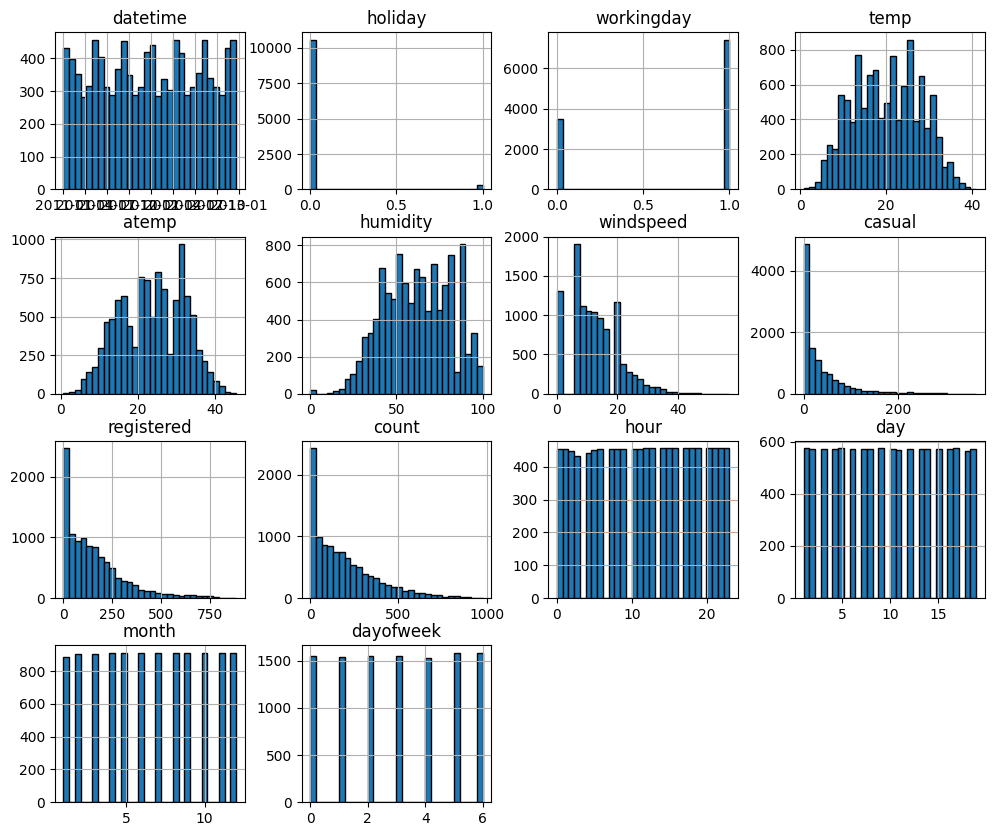

In [12]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(12, 10), bins=30, edgecolor='black')

**Rerun the model with the same settings as before, just with more features**

In [ ]:
# Drop unnecessary columns before training
#train_data = train.drop(columns=['casual', 'registered'])

# Retrain the AutoGluon model with the new features
predictor_new_features = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data, 
    time_limit=600,  # 10 minutes
    presets="best_quality"
)

New score of 0.69776

**Hyper parameter optimization**

In [ ]:
# Drop unnecessary columns before training
train_data = train.drop(columns=['casual', 'registered'])

# Define hyperparameters for individual models
hyperparameters = {
    "GBM": {"num_boost_round": 100},  # LightGBM with max 100 boosting rounds
    "XGB": {"n_estimators": 100, "learning_rate": 0.05},  # XGBoost with 100 trees and a lower LR
    "CAT": {"iterations": 200},  # CatBoost with 200 iterations
    "NN_TORCH": {"num_epochs": 20}  # Neural Network with 20 epochs
}

# Define hyperparameter tuning settings
hyperparameter_tune_kwargs = {
    "num_trials": 10,  # Try 10 different configurations
    "scheduler": "local",  # Run tuning locally
    "searcher": "bayes"  # Use Bayesian Optimization
}

# Train the AutoGluon model with hyperparameter tuning
predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data,
    time_limit=1200,  # Increase training time to 20 minutes for better tuning
    presets="best_quality",
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

In [ ]:
predictor_new_hpo.fit_summary()

In [ ]:
# Display full leaderboard with extra model details
leaderboard_df = predictor_new_hpo.leaderboard(extra_info=True)

# Show all rows and full column width
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

# Print leaderboard
print(leaderboard_df)

In [ ]:
predictor_new_hpo.model_best

In [ ]:
# Refit the best model on the full dataset
predictor_new_hpo.refit_full()

In [ ]:
# Generate predictions on the test dataset
predictions = predictor_new_hpo.predict(test)

# Display the first few predictions
predictions.head() 

In [ ]:
# Create a submission DataFrame
submission = pd.DataFrame({
    "datetime": test["datetime"],  # Use the datetime from the test dataset
    "count": predictions           # Use our predicted values
})

# Display the first few rows
submission.head()

In [ ]:
# Save submission to a CSV file (without the index column)
submission.to_csv("/kaggle/working/submission2.csv", index=False)

New score of 0.49311